In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os, sys
import pyedflib
import urllib.request
from tqdm import tqdm
from scipy import io
from math import sqrt
from pyedflib import highlevel

MMI_SUBJECT = 100
MMI_TRIAL = 14
MMI_CHANNEL = 64

file_path='./eegmmidb_edf/S'

for i in range(1):
    for j in range(4,5):
        path = file_path+str(i+1).zfill(3)+'/s'+str(i+1).zfill(3)+'R'+str(j+1).zfill(2)+'.edf'
        signals, signal_header, header = highlevel.read_edf(path)
        
        for k in range(64):
            print(k+1, signal_header[k]['label'])

1 Fc5.
2 Fc3.
3 Fc1.
4 Fcz.
5 Fc2.
6 Fc4.
7 Fc6.
8 C5..
9 C3..
10 C1..
11 Cz..
12 C2..
13 C4..
14 C6..
15 Cp5.
16 Cp3.
17 Cp1.
18 Cpz.
19 Cp2.
20 Cp4.
21 Cp6.
22 Fp1.
23 Fpz.
24 Fp2.
25 Af7.
26 Af3.
27 Afz.
28 Af4.
29 Af8.
30 F7..
31 F5..
32 F3..
33 F1..
34 Fz..
35 F2..
36 F4..
37 F6..
38 F8..
39 Ft7.
40 Ft8.
41 T7..
42 T8..
43 T9..
44 T10.
45 Tp7.
46 Tp8.
47 P7..
48 P5..
49 P3..
50 P1..
51 Pz..
52 P2..
53 P4..
54 P6..
55 P8..
56 Po7.
57 Po3.
58 Poz.
59 Po4.
60 Po8.
61 O1..
62 Oz..
63 O2..
64 Iz..


# 64 channel  -> 32 channel DEAP

| Channel Name | Deap Num  | EPOC Num |
|------|------|------|
| Fp1 | 22  | 1  |
| AF3 | 26  | 2  |
| F3 | 32  | 3  |
| F7  | 30 | 4  |
| Fc5  | 1 | 5  |
| Fc1  | 3 | 6  |
| C3  | 9 | 7  |
| T7  | 41 | 8  |
| Cp5  | 15 | 9  |
| Cp1  | 17 | 10  |
| P3  | 49 | 11  |
| P7  | 47 | 12  |
| Po3  | 57 | 13  |
| O1  | 61 | 14  |
| Oz  | 62 | 15  |
| Pz  | 51 | 16  |
| Fp2  | 24  | 17  |
| Af4  | 28 | 18  |
| Fz  | 34  | 19  |
| F4  | 36  | 20  |
| F8  | 38 | 21  |
| Fc6  | 7 | 22  |
| Fc2  | 5 | 23  |
| Cz  | 11 | 24  |
| C4  | 13 | 25  |
| T8  | 42 | 26  |
| Cp6  | 21 | 27  |
| Cp2  | 19 | 28  |
| P4  | 53 | 29  |
| P8  | 55 | 30  |
| PO4  | 59 | 31  |
| O2  | 63 | 32  |

# Only 32 Chan Used

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os, sys
from tqdm import tqdm
from scipy import io
    
MMI_SUBJECT = 100
MMI_CHANNEL = 64
channel_num = [21, 25, 31, 29, 0, 2, 8, 40, 14 ,16 ,48, 46, 56, 60, 61, 50, 
               23, 27, 33, 35, 37, 6, 4, 10, 12, 41, 20, 18, 52, 54, 58, 62]

train32chan_data = []
test32chan_data = []

load_path = './eegmmidb_feature/S'

for i in tqdm(range(MMI_SUBJECT)):
    if(i == 105): continue
    path = load_path+str(i+1).zfill(3)+'/'
    temp = np.load(path+'user_id_20_8.npy')
    temp2 = temp[:,:,channel_num]
    temp3 = temp2[:,channel_num,:]
    cut_off = int(len(temp3) * 0.8)
    train32chan_data.append(temp3[:cut_off])
    test32chan_data.append(temp3[cut_off:])
       
train32chan_data = np.array(train32chan_data)
test32chan_data = np.array(test32chan_data)
print(train32chan_data.shape, test32chan_data.shape)

train32chan_data = train32chan_data.reshape(-1,32,32,1)
test32chan_data = test32chan_data.reshape(-1,32,32,1)
print(train32chan_data.shape, test32chan_data.shape)

train_label = np.zeros((len(train32chan_data), MMI_SUBJECT))
test_label = np.zeros((len(test32chan_data), MMI_SUBJECT))

for i in range(len(train_label)):
    k = int(i/(len(train_label)/100))
    train_label[i][k] = 1

for i in range(len(test_label)):
    k = int(i/(len(test_label)/100))
    test_label[i][k] = 1

print(train_label.shape, test_label.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.08it/s]


(100, 780, 32, 32) (100, 195, 32, 32)
(78000, 32, 32, 1) (19500, 32, 32, 1)
(78000, 100) (19500, 100)


In [2]:
#shuffle
idx = [i for i in range(len(train32chan_data))]
np.random.shuffle(idx)
train32chan_data = train32chan_data[idx]
train_label = train_label[idx]

In [3]:
import keras
from keras.models import Model
from keras.layers import Flatten, Reshape, Conv2D, Dense, Input, Activation
from keras.layers import Dropout, BatchNormalization, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

Using TensorFlow backend.


In [4]:
inputs = Input(shape=(32,32,1))
x = Conv2D(32, (1,32), activation='relu')(inputs)
x = Reshape((32,32,1))(x)
x = Conv2D(8, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Conv2D(8, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Conv2D(8, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(2048, activation='relu')(x)
prediction = Dense(MMI_SUBJECT, activation='sigmoid')(x)


sgd = keras.optimizers.sgd()
adam = keras.optimizers.Adam(learning_rate=0.0005)
model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer=sgd, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callback_list = [ModelCheckpoint(filepath='temp.h5',
                                monitor='val_accuracy', save_best_only=True)]
              
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 1, 32)         1056      
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 8)         32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 8)         584 

In [5]:
history = model.fit(train32chan_data, train_label, epochs=100, batch_size = 20,
                   validation_data=(test32chan_data, test_label), callbacks=callback_list, verbose=2)

Train on 78000 samples, validate on 19500 samples
Epoch 1/100
 - 34s - loss: 4.0516 - accuracy: 0.1019 - val_loss: 2.8391 - val_accuracy: 0.3311
Epoch 2/100
 - 30s - loss: 2.1559 - accuracy: 0.4620 - val_loss: 1.8565 - val_accuracy: 0.5371
Epoch 3/100
 - 31s - loss: 1.5408 - accuracy: 0.5973 - val_loss: 1.8199 - val_accuracy: 0.5451
Epoch 4/100
 - 30s - loss: 1.2713 - accuracy: 0.6566 - val_loss: 1.3282 - val_accuracy: 0.6622
Epoch 5/100
 - 29s - loss: 1.0965 - accuracy: 0.6995 - val_loss: 1.2734 - val_accuracy: 0.6724
Epoch 6/100
 - 29s - loss: 0.9738 - accuracy: 0.7283 - val_loss: 1.1903 - val_accuracy: 0.6912
Epoch 7/100
 - 29s - loss: 0.8762 - accuracy: 0.7538 - val_loss: 1.1859 - val_accuracy: 0.6923
Epoch 8/100
 - 29s - loss: 0.8039 - accuracy: 0.7702 - val_loss: 1.1353 - val_accuracy: 0.7080
Epoch 9/100
 - 30s - loss: 0.7320 - accuracy: 0.7885 - val_loss: 1.1100 - val_accuracy: 0.7137
Epoch 10/100
 - 30s - loss: 0.6703 - accuracy: 0.8023 - val_loss: 1.2266 - val_accuracy: 0.6928

Epoch 86/100
 - 30s - loss: 0.0371 - accuracy: 0.9879 - val_loss: 1.9781 - val_accuracy: 0.6993
Epoch 87/100
 - 30s - loss: 0.0356 - accuracy: 0.9887 - val_loss: 1.9460 - val_accuracy: 0.6946
Epoch 88/100
 - 29s - loss: 0.0351 - accuracy: 0.9888 - val_loss: 1.9412 - val_accuracy: 0.7007
Epoch 89/100
 - 29s - loss: 0.0348 - accuracy: 0.9885 - val_loss: 1.9400 - val_accuracy: 0.7023
Epoch 90/100
 - 30s - loss: 0.0365 - accuracy: 0.9877 - val_loss: 1.9698 - val_accuracy: 0.7003
Epoch 91/100
 - 29s - loss: 0.0348 - accuracy: 0.9886 - val_loss: 1.9396 - val_accuracy: 0.6996
Epoch 92/100
 - 30s - loss: 0.0364 - accuracy: 0.9880 - val_loss: 1.9896 - val_accuracy: 0.7021
Epoch 93/100
 - 30s - loss: 0.0324 - accuracy: 0.9889 - val_loss: 2.0088 - val_accuracy: 0.6991
Epoch 94/100
 - 30s - loss: 0.0329 - accuracy: 0.9891 - val_loss: 1.9888 - val_accuracy: 0.6970
Epoch 95/100
 - 30s - loss: 0.0322 - accuracy: 0.9892 - val_loss: 1.9155 - val_accuracy: 0.7045
Epoch 96/100
 - 29s - loss: 0.0320 - acc

accuracy: 0.7166666388511658


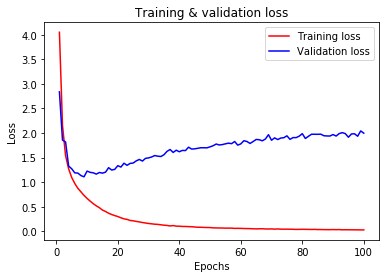

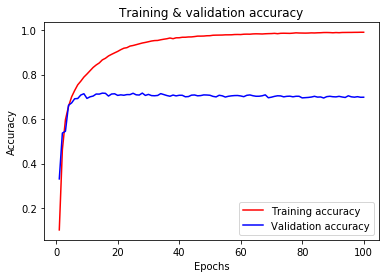

In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print('accuracy:',max(val_acc))

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 32 Channel MARS TEST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os, sys
from tqdm import tqdm
from scipy import io
    
MMI_SUBJECT = 100
MMI_CHANNEL = 64
channel_num = [21, 25, 31, 29, 0, 2, 8, 40, 14 ,16 ,48, 46, 56, 60, 61, 50, 
               23, 27, 33, 35, 37, 6, 4, 10, 12, 41, 20, 18, 52, 54, 58, 62]

train32chan_data = []
test32chan_data = []
train64chan_data = []
test64chan_data = []

load_path = './eegmmidb_feature/S'

for i in tqdm(range(MMI_SUBJECT)):
    if(i == 105): continue
    path = load_path+str(i+1).zfill(3)+'/'
    temp = np.load(path+'user_id_20_8.npy')
    temp2 = temp[:,:,channel_num]
    temp3 = temp2[:,channel_num,:]
    cut_off = int(len(temp3) * 0.8)
    train64chan_data.append(temp[:cut_off])
    test64chan_data.append(temp[cut_off:])
    train32chan_data.append(temp3[:cut_off])
    test32chan_data.append(temp3[cut_off:])
       
train64chan_data = np.array(train64chan_data)
test64chan_data = np.array(test64chan_data)
train32chan_data = np.array(train32chan_data)
test32chan_data = np.array(test32chan_data)
print(train64chan_data.shape, test64chan_data.shape)
print(train32chan_data.shape, test32chan_data.shape)

train64chan_data = train64chan_data.reshape(-1,64,64,1)
test64chan_data = test64chan_data.reshape(-1,64,64,1)
train32chan_data = train32chan_data.reshape(-1,32,32,1)
test32chan_data = test32chan_data.reshape(-1,32,32,1)
print(train64chan_data.shape, test64chan_data.shape)
print(train32chan_data.shape, test32chan_data.shape)

train_label = np.zeros((len(train32chan_data), MMI_SUBJECT))
test_label = np.zeros((len(test32chan_data), MMI_SUBJECT))

for i in range(len(train_label)):
    k = int(i/(len(train_label)/100))
    train_label[i][k] = 1

for i in range(len(test_label)):
    k = int(i/(len(test_label)/100))
    test_label[i][k] = 1

print(train_label.shape, test_label.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.57it/s]


(100, 780, 64, 64) (100, 195, 64, 64)
(100, 780, 32, 32) (100, 195, 32, 32)
(78000, 64, 64, 1) (19500, 64, 64, 1)
(78000, 32, 32, 1) (19500, 32, 32, 1)
(78000, 100) (19500, 100)


In [2]:
#shuffle
idx = [i for i in range(len(train64chan_data))]
np.random.shuffle(idx)
train64chan_data = train64chan_data[idx]
train32chan_data = train32chan_data[idx]
train_label = train_label[idx]

In [3]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Reshape, Conv2D, Dense, Input, Activation
from keras.layers import Dropout, BatchNormalization, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

Using TensorFlow backend.


In [4]:
teacher_model = keras.models.load_model('MMI_44.h5')
tea_feature = teacher_model.layers[-2].output    

inputs = Input(shape=(32,32,1), name='input')
x = Conv2D(32, (1,32), activation='relu', name='1dconv1')(inputs)
x = Reshape((32,32,1), name='reshape')(x)
x = Conv2D(8, (3,3), activation='relu', name='2dconv1')(x)
x = BatchNormalization(name='bn1')(x)
x = Dropout(0.4, name='dp1')(x)
x = Conv2D(8, (3,3), activation='relu', name='2dconv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Dropout(0.4, name='dp2')(x)
x = Conv2D(8, (3,3), activation='relu', name='2dconv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Dropout(0.4, name='dp3')(x)
x = Flatten(name='flat')(x)
std_feature = Dense(2048, activation='relu', name='fc')(x)
prediction = Dense(MMI_SUBJECT, activation='sigmoid', name='pred')(std_feature)
student_model = Model(inputs=inputs, outputs=prediction)

model = Model(inputs=[teacher_model.input, student_model.input], outputs=student_model.output)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 1)         0         
_________________________________________________________________
1dconv1 (Conv2D)             (None, 32, 1, 32)         1056      
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 1)         0         
_________________________________________________________________
2dconv1 (Conv2D)             (None, 30, 30, 8)         80        
_________________________________________________________________
bn1 (BatchNormalization)     (None, 30, 30, 8)         32        
_________________________________________________________________
dp1 (Dropout)                (None, 30, 30, 8)         0         
_________________________________________________________________
2dconv2 (Conv2D)             (None, 28, 28, 8)         584 

In [5]:
def MARS_loss(y_true, y_pred):
    alpha = 10
    loss = keras.losses.categorical_crossentropy(y_true, y_pred) + alpha * K.mean(K.square(tea_feature-std_feature))
    return loss

sgd = keras.optimizers.sgd()
adam = keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=sgd,
              loss=MARS_loss,
              metrics=['accuracy']

for l in teacher_model.layers:
    l.trainable = False

In [8]:
history = model.fit([train64chan_data, train32chan_data], train_label, epochs=150, batch_size=20,
                    validation_data=([test64chan_data, test32chan_data], test_label), verbose=2)

Train on 78000 samples, validate on 19500 samples
Epoch 1/150
 - 42s - loss: 42.2105 - accuracy: 0.8501 - val_loss: 26.7755 - val_accuracy: 0.7724
Epoch 2/150
 - 41s - loss: 42.2105 - accuracy: 0.8525 - val_loss: 27.2555 - val_accuracy: 0.7529
Epoch 3/150
 - 41s - loss: 42.1888 - accuracy: 0.8534 - val_loss: 26.7673 - val_accuracy: 0.7686
Epoch 4/150
 - 41s - loss: 42.1779 - accuracy: 0.8529 - val_loss: 26.4952 - val_accuracy: 0.7689
Epoch 5/150
 - 41s - loss: 42.1872 - accuracy: 0.8544 - val_loss: 26.6136 - val_accuracy: 0.7629
Epoch 6/150
 - 42s - loss: 42.1962 - accuracy: 0.8565 - val_loss: 26.6181 - val_accuracy: 0.7680
Epoch 7/150
 - 42s - loss: 42.1686 - accuracy: 0.8562 - val_loss: 26.5920 - val_accuracy: 0.7569
Epoch 8/150
 - 41s - loss: 42.1640 - accuracy: 0.8578 - val_loss: 26.7609 - val_accuracy: 0.7861
Epoch 9/150
 - 41s - loss: 42.1446 - accuracy: 0.8588 - val_loss: 26.8659 - val_accuracy: 0.7670
Epoch 10/150
 - 41s - loss: 42.1726 - accuracy: 0.8567 - val_loss: 27.1793 - 

Epoch 85/150
 - 41s - loss: 41.7696 - accuracy: 0.8971 - val_loss: 26.4322 - val_accuracy: 0.7781
Epoch 86/150
 - 42s - loss: 41.7928 - accuracy: 0.8959 - val_loss: 26.5895 - val_accuracy: 0.7738
Epoch 87/150
 - 41s - loss: 41.7566 - accuracy: 0.8986 - val_loss: 26.6893 - val_accuracy: 0.7729
Epoch 88/150
 - 41s - loss: 41.7752 - accuracy: 0.8963 - val_loss: 26.9843 - val_accuracy: 0.7766
Epoch 89/150
 - 41s - loss: 41.7839 - accuracy: 0.8981 - val_loss: 27.0674 - val_accuracy: 0.7744
Epoch 90/150
 - 41s - loss: 41.7811 - accuracy: 0.8955 - val_loss: 26.5368 - val_accuracy: 0.7680
Epoch 91/150
 - 41s - loss: 41.7622 - accuracy: 0.8969 - val_loss: 26.6559 - val_accuracy: 0.7603
Epoch 92/150
 - 41s - loss: 41.7797 - accuracy: 0.8954 - val_loss: 26.4540 - val_accuracy: 0.7812
Epoch 93/150
 - 41s - loss: 41.7830 - accuracy: 0.8982 - val_loss: 26.4788 - val_accuracy: 0.7912
Epoch 94/150
 - 41s - loss: 41.7644 - accuracy: 0.8983 - val_loss: 26.4892 - val_accuracy: 0.7820
Epoch 95/150
 - 41s 

accuracy: 0.795846164226532


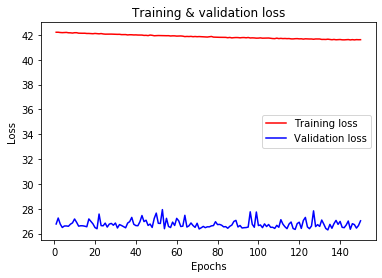

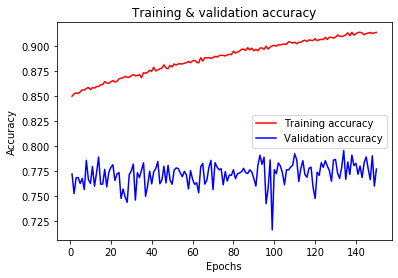

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print('accuracy:',max(val_acc))

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 64 Channel -> 14 Channel
| Channel Name | Deap Num  | EPOC Num |
|------|------|------|
| AF3 | 26  | 1  |
| F7  | 30 | 2  |
| Fc5  | 1 | 3  |
| F3 | 32  | 4  |
| T7  | 41 | 5  |
| P7  | 47 | 6  |
| O1  | 61 | 7  |
| AF4  | 28 | 8  |
| F4  | 36  | 9  |
| F8  | 38 | 10  |
| Fc6  | 7 | 11  |
| T8  | 42 | 12  |
| P8  | 55 | 13  |
| O2  | 63 | 14  |

# Only 14 Chan Used

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os, sys
from tqdm import tqdm
from scipy import io
    
MMI_SUBJECT = 100
MMI_CHANNEL = 64
channel_num = [25, 31, 29, 0, 40, 46, 60, 27, 35, 37, 6, 41, 54, 62]

train14chan_data = []
test14chan_data = []

load_path = './eegmmidb_feature/S'

for i in tqdm(range(MMI_SUBJECT)):
    if(i == 105): continue
    path = load_path+str(i+1).zfill(3)+'/'
    temp = np.load(path+'user_id_20_8.npy')
    temp2 = temp[:,:,channel_num]
    temp3 = temp2[:,channel_num,:]
    cut_off = int(len(temp3) * 0.8)
    train14chan_data.append(temp3[:cut_off])
    test14chan_data.append(temp3[cut_off:])
       
train14chan_data = np.array(train14chan_data)
test14chan_data = np.array(test14chan_data)
print(train14chan_data.shape, test14chan_data.shape)

train14chan_data = train14chan_data.reshape(-1,14,14,1)
test14chan_data = test14chan_data.reshape(-1,14,14,1)
print(train14chan_data.shape, test14chan_data.shape)

train_label = np.zeros((len(train14chan_data), MMI_SUBJECT))
test_label = np.zeros((len(test14chan_data), MMI_SUBJECT))

for i in range(len(train_label)):
    k = int(i/(len(train_label)/100))
    train_label[i][k] = 1

for i in range(len(test_label)):
    k = int(i/(len(test_label)/100))
    test_label[i][k] = 1

print(train_label.shape, test_label.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.44it/s]


(100, 780, 14, 14) (100, 195, 14, 14)
(78000, 14, 14, 1) (19500, 14, 14, 1)
(78000, 100) (19500, 100)


In [3]:
#shuffle
idx = [i for i in range(len(train14chan_data))]
np.random.shuffle(idx)
train14chan_data = train14chan_data[idx]
train_label = train_label[idx]

In [4]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Reshape, Conv2D, Dense, Input, Activation
from keras.layers import Dropout, BatchNormalization, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

Using TensorFlow backend.


In [5]:
inputs = Input(shape=(14,14,1))
x = Conv2D(14, (1,14), activation='relu')(inputs)
x = Reshape((14,14,1))(x)
x = Conv2D(8, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Conv2D(8, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Conv2D(8, (3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(2048, activation='relu')(x)
prediction = Dense(MMI_SUBJECT, activation='sigmoid')(x)


sgd = keras.optimizers.sgd()
adam = keras.optimizers.Adam(learning_rate=0.0005)
model = Model(inputs=inputs, outputs=prediction)
model.compile(optimizer=sgd, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callback_list = [ModelCheckpoint(filepath='temp.h5',
                                monitor='val_accuracy', save_best_only=True)]
              
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 1, 14)         210       
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 8)         32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 8)         584 

In [6]:
history = model.fit(train14chan_data, train_label, epochs=100, batch_size = 20,
                   validation_data=(test14chan_data, test_label), callbacks=callback_list, verbose=2)

Train on 78000 samples, validate on 19500 samples
Epoch 1/100
 - 28s - loss: 4.4572 - accuracy: 0.0313 - val_loss: 4.3315 - val_accuracy: 0.0514
Epoch 2/100
 - 24s - loss: 4.0619 - accuracy: 0.0902 - val_loss: 3.7943 - val_accuracy: 0.1430
Epoch 3/100
 - 24s - loss: 3.6535 - accuracy: 0.1558 - val_loss: 3.4480 - val_accuracy: 0.2178
Epoch 4/100
 - 24s - loss: 3.4067 - accuracy: 0.2001 - val_loss: 3.2164 - val_accuracy: 0.2525
Epoch 5/100
 - 24s - loss: 3.2423 - accuracy: 0.2286 - val_loss: 3.0948 - val_accuracy: 0.2746
Epoch 6/100
 - 24s - loss: 3.1398 - accuracy: 0.2479 - val_loss: 2.9793 - val_accuracy: 0.2996
Epoch 7/100
 - 24s - loss: 3.0481 - accuracy: 0.2651 - val_loss: 2.9186 - val_accuracy: 0.3047
Epoch 8/100
 - 27s - loss: 2.9801 - accuracy: 0.2784 - val_loss: 2.8509 - val_accuracy: 0.3264
Epoch 9/100
 - 27s - loss: 2.9259 - accuracy: 0.2871 - val_loss: 2.8167 - val_accuracy: 0.3323
Epoch 10/100
 - 25s - loss: 2.8819 - accuracy: 0.2964 - val_loss: 2.7754 - val_accuracy: 0.3326

Epoch 86/100
 - 24s - loss: 1.9532 - accuracy: 0.4748 - val_loss: 2.5980 - val_accuracy: 0.3856
Epoch 87/100
 - 24s - loss: 1.9436 - accuracy: 0.4776 - val_loss: 2.6213 - val_accuracy: 0.3876
Epoch 88/100
 - 25s - loss: 1.9404 - accuracy: 0.4771 - val_loss: 2.6031 - val_accuracy: 0.3869
Epoch 89/100
 - 24s - loss: 1.9354 - accuracy: 0.4776 - val_loss: 2.6188 - val_accuracy: 0.3849
Epoch 90/100
 - 24s - loss: 1.9320 - accuracy: 0.4778 - val_loss: 2.6180 - val_accuracy: 0.3876
Epoch 91/100
 - 24s - loss: 1.9246 - accuracy: 0.4811 - val_loss: 2.6159 - val_accuracy: 0.3842
Epoch 92/100
 - 24s - loss: 1.9175 - accuracy: 0.4820 - val_loss: 2.6567 - val_accuracy: 0.3822
Epoch 93/100
 - 24s - loss: 1.9095 - accuracy: 0.4831 - val_loss: 2.6647 - val_accuracy: 0.3802
Epoch 94/100
 - 24s - loss: 1.9075 - accuracy: 0.4823 - val_loss: 2.6538 - val_accuracy: 0.3823
Epoch 95/100
 - 24s - loss: 1.9028 - accuracy: 0.4842 - val_loss: 2.6263 - val_accuracy: 0.3822
Epoch 96/100
 - 24s - loss: 1.8978 - acc

accuracy: 0.39553844928741455


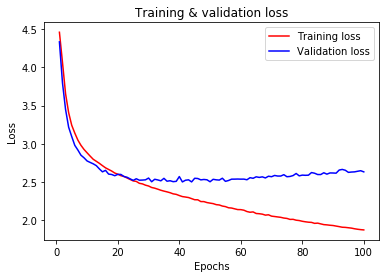

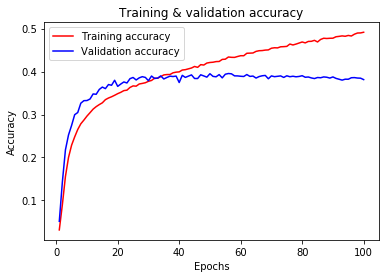

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print('accuracy:',max(val_acc))

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 14 Channel MARS TEST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os, sys
from tqdm import tqdm
from scipy import io
    
MMI_SUBJECT = 100
MMI_CHANNEL = 64
channel_num = [25, 31, 29, 0, 40, 46, 60, 27, 35, 37, 6, 41, 54, 62]

train14chan_data = []
test14chan_data = []
train64chan_data = []
test64chan_data = []

load_path = './eegmmidb_feature/S'

for i in tqdm(range(MMI_SUBJECT)):
    if(i == 105): continue
    path = load_path+str(i+1).zfill(3)+'/'
    temp = np.load(path+'user_id_20_8.npy')
    temp2 = temp[:,:,channel_num]
    temp3 = temp2[:,channel_num,:]
    cut_off = int(len(temp3) * 0.8)
    train64chan_data.append(temp[:cut_off])
    test64chan_data.append(temp[cut_off:])
    train14chan_data.append(temp3[:cut_off])
    test14chan_data.append(temp3[cut_off:])
       
train64chan_data = np.array(train64chan_data)
test64chan_data = np.array(test64chan_data)
train14chan_data = np.array(train14chan_data)
test14chan_data = np.array(test14chan_data)
print(train64chan_data.shape, test64chan_data.shape)
print(train14chan_data.shape, test14chan_data.shape)

train64chan_data = train64chan_data.reshape(-1,64,64,1)
test64chan_data = test64chan_data.reshape(-1,64,64,1)
train14chan_data = train14chan_data.reshape(-1,14,14,1)
test14chan_data = test14chan_data.reshape(-1,14,14,1)
print(train64chan_data.shape, test64chan_data.shape)
print(train14chan_data.shape, test14chan_data.shape)

train_label = np.zeros((len(train14chan_data), MMI_SUBJECT))
test_label = np.zeros((len(test14chan_data), MMI_SUBJECT))

for i in range(len(train_label)):
    k = int(i/(len(train_label)/100))
    train_label[i][k] = 1

for i in range(len(test_label)):
    k = int(i/(len(test_label)/100))
    test_label[i][k] = 1

print(train_label.shape, test_label.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.50it/s]


(100, 780, 64, 64) (100, 195, 64, 64)
(100, 780, 14, 14) (100, 195, 14, 14)
(78000, 64, 64, 1) (19500, 64, 64, 1)
(78000, 14, 14, 1) (19500, 14, 14, 1)
(78000, 100) (19500, 100)


In [2]:
#shuffle
idx = [i for i in range(len(train14chan_data))]
np.random.shuffle(idx)
train64chan_data = train64chan_data[idx]
train14chan_data = train14chan_data[idx]
train_label = train_label[idx]

In [5]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Reshape, Conv2D, Dense, Input, Activation
from keras.layers import Dropout, BatchNormalization, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

In [6]:
teacher_model = keras.models.load_model('MMI_44.h5')
for l in teacher_model.layers:
    l.trainable = False
tea_feature = teacher_model.layers[-2].output    

inputs = Input(shape=(14,14,1), name='input')
x = Conv2D(14, (1,14), activation='relu', name='1dconv1')(inputs)
x = Reshape((14,14,1), name='reshape')(x)
x = Conv2D(8, (3,3), activation='relu', name='2dconv1')(x)
x = BatchNormalization(name='bn1')(x)
x = Dropout(0.4, name='dp1')(x)
x = Conv2D(8, (3,3), activation='relu', name='2dconv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Dropout(0.4, name='dp2')(x)
x = Conv2D(8, (3,3), activation='relu', name='2dconv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Dropout(0.4, name='dp3')(x)
x = Flatten(name='flat')(x)
std_feature = Dense(2048, activation='relu', name='fc')(x)
prediction = Dense(MMI_SUBJECT, activation='sigmoid', name='pred')(std_feature)
student_model = Model(inputs=inputs, outputs=prediction)

model = Model(inputs=[teacher_model.input, student_model.input], outputs=student_model.output)

model.summary()
teacher_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 14, 14, 1)         0         
_________________________________________________________________
1dconv1 (Conv2D)             (None, 14, 1, 14)         210       
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 1)         0         
_________________________________________________________________
2dconv1 (Conv2D)             (None, 12, 12, 8)         80        
_________________________________________________________________
bn1 (BatchNormalization)     (None, 12, 12, 8)         32        
_________________________________________________________________
dp1 (Dropout)                (None, 12, 12, 8)         0         
_________________________________________________________________
2dconv2 (Conv2D)             (None, 10, 10, 8)         584 

C:\Users\jae\Anaconda3\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Total params: 110,656,408
Trainable params: 55,328,180
Non-trainable params: 55,328,228
_________________________________________________________________


In [7]:
def MARS_loss(y_true, y_pred):
    alpha = 10
    loss = keras.losses.categorical_crossentropy(y_true, y_pred) + alpha * K.mean(K.square(tea_feature-std_feature))
    return loss

sgd = keras.optimizers.sgd(0.007)
adam = keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=sgd,
              loss=MARS_loss,
              metrics=['accuracy'])

In [10]:
history = model.fit([train64chan_data, train14chan_data], train_label, epochs=100, batch_size = 20,
                   validation_data=([test64chan_data, test14chan_data], test_label), verbose=2)

Train on 78000 samples, validate on 19500 samples
Epoch 1/100
 - 34s - loss: 54.2188 - accuracy: 0.1888 - val_loss: 39.0470 - val_accuracy: 0.1716
Epoch 2/100
 - 34s - loss: 54.2150 - accuracy: 0.1884 - val_loss: 38.8659 - val_accuracy: 0.2410
Epoch 3/100
 - 34s - loss: 54.2188 - accuracy: 0.1872 - val_loss: 38.8454 - val_accuracy: 0.2395
Epoch 4/100
 - 34s - loss: 54.2146 - accuracy: 0.1900 - val_loss: 39.0636 - val_accuracy: 0.2466
Epoch 5/100
 - 34s - loss: 54.1995 - accuracy: 0.1923 - val_loss: 38.8171 - val_accuracy: 0.2319
Epoch 6/100
 - 34s - loss: 54.2050 - accuracy: 0.1916 - val_loss: 38.8421 - val_accuracy: 0.2236
Epoch 7/100
 - 34s - loss: 54.1791 - accuracy: 0.1937 - val_loss: 38.9374 - val_accuracy: 0.2195
Epoch 8/100
 - 34s - loss: 54.1960 - accuracy: 0.1911 - val_loss: 38.8597 - val_accuracy: 0.1962
Epoch 9/100
 - 34s - loss: 54.1766 - accuracy: 0.1951 - val_loss: 38.8144 - val_accuracy: 0.2308
Epoch 10/100
 - 34s - loss: 54.1842 - accuracy: 0.1927 - val_loss: 38.8671 - 

Epoch 85/100
 - 34s - loss: 53.9302 - accuracy: 0.2152 - val_loss: 38.5150 - val_accuracy: 0.2838
Epoch 86/100
 - 34s - loss: 53.9108 - accuracy: 0.2145 - val_loss: 38.6816 - val_accuracy: 0.2743
Epoch 87/100
 - 34s - loss: 53.9320 - accuracy: 0.2147 - val_loss: 38.6096 - val_accuracy: 0.2529
Epoch 88/100
 - 34s - loss: 53.9182 - accuracy: 0.2189 - val_loss: 38.5607 - val_accuracy: 0.2093
Epoch 89/100
 - 34s - loss: 53.9156 - accuracy: 0.2151 - val_loss: 38.5120 - val_accuracy: 0.2610
Epoch 90/100
 - 33s - loss: 53.9042 - accuracy: 0.2140 - val_loss: 38.7021 - val_accuracy: 0.2745
Epoch 91/100
 - 33s - loss: 53.9021 - accuracy: 0.2161 - val_loss: 38.6530 - val_accuracy: 0.2199
Epoch 92/100
 - 33s - loss: 53.9179 - accuracy: 0.2151 - val_loss: 38.5348 - val_accuracy: 0.2631
Epoch 93/100
 - 33s - loss: 53.8950 - accuracy: 0.2214 - val_loss: 38.6141 - val_accuracy: 0.2729
Epoch 94/100
 - 33s - loss: 53.9023 - accuracy: 0.2152 - val_loss: 38.5323 - val_accuracy: 0.2484
Epoch 95/100
 - 33s 

accuracy: 0.29630768299102783


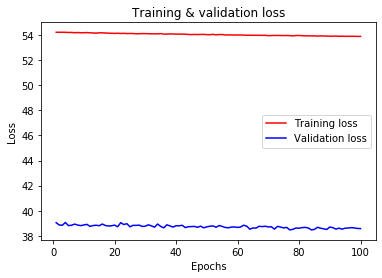

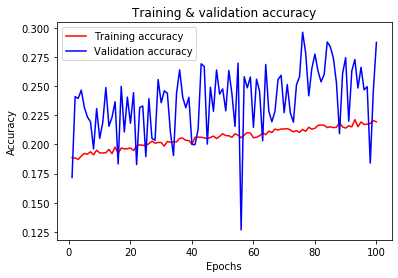

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print('accuracy:',max(val_acc))

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 32 Chan + 32 Chan MARS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os, sys
from tqdm import tqdm
from scipy import io
    
MMI_SUBJECT = 100
MMI_CHANNEL = 64
channel_num = [21, 25, 31, 29, 0, 2, 8, 40, 14 ,16 ,48, 46, 56, 60, 61, 50, 
               23, 27, 33, 35, 37, 6, 4, 10, 12, 41, 20, 18, 52, 54, 58, 62]

train32chan_data = []
test32chan_data = []
train64chan_data = []
test64chan_data = []

load_path = './eegmmidb_feature/S'

for i in tqdm(range(MMI_SUBJECT)):
    if(i == 105): continue
    path = load_path+str(i+1).zfill(3)+'/'
    temp = np.load(path+'user_id_20_8.npy')
    temp2 = temp[:,:,channel_num]
    temp3 = temp2[:,channel_num,:]
    cut_off = int(len(temp3) * 0.8)
    train64chan_data.append(temp[:cut_off])
    test64chan_data.append(temp[cut_off:])
    train32chan_data.append(temp3[:cut_off])
    test32chan_data.append(temp3[cut_off:])
       
train64chan_data = np.array(train64chan_data)
test64chan_data = np.array(test64chan_data)
train32chan_data = np.array(train32chan_data)
test32chan_data = np.array(test32chan_data)
print(train64chan_data.shape, test64chan_data.shape)
print(train32chan_data.shape, test32chan_data.shape)

train64chan_data = train64chan_data.reshape(-1,64,64,1)
test64chan_data = test64chan_data.reshape(-1,64,64,1)
train32chan_data = train32chan_data.reshape(-1,32,32,1)
test32chan_data = test32chan_data.reshape(-1,32,32,1)
print(train64chan_data.shape, test64chan_data.shape)
print(train32chan_data.shape, test32chan_data.shape)

train_label = np.zeros((len(train32chan_data), MMI_SUBJECT))
test_label = np.zeros((len(test32chan_data), MMI_SUBJECT))

for i in range(len(train_label)):
    k = int(i/(len(train_label)/100))
    train_label[i][k] = 1

for i in range(len(test_label)):
    k = int(i/(len(test_label)/100))
    test_label[i][k] = 1

print(train_label.shape, test_label.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.51it/s]


(100, 780, 64, 64) (100, 195, 64, 64)
(100, 780, 32, 32) (100, 195, 32, 32)
(78000, 64, 64, 1) (19500, 64, 64, 1)
(78000, 32, 32, 1) (19500, 32, 32, 1)
(78000, 100) (19500, 100)


In [2]:
#shuffle
idx = [i for i in range(len(train32chan_data))]
np.random.shuffle(idx)
train32chan_data = train32chan_data[idx]
train_label = train_label[idx]

In [3]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Reshape, Conv2D, Dense, Input, Activation
from keras.layers import Dropout, BatchNormalization, MaxPool2D, Average
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

Using TensorFlow backend.


In [4]:
teacher_model = keras.models.load_model('MMI_44.h5')
#for l in teacher_model.layers:
#    l.trainable = False
tea_feature = teacher_model.layers[-2].output    

inputs = Input(shape=(32,32,1), name='input')
#MARS
x = Conv2D(32, (1,32), activation='relu', name='1dconv1')(inputs)
x = Reshape((32,32,1), name='reshape')(x)
x = Conv2D(8, (3,3), activation='relu', name='2dconv1')(x)
x = BatchNormalization(name='bn1')(x)
x = Dropout(0.4, name='dp1')(x)
x = Conv2D(8, (3,3), activation='relu', name='2dconv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Dropout(0.4, name='dp2')(x)
x = Conv2D(8, (3,3), activation='relu', name='2dconv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Dropout(0.4, name='dp3')(x)
x = Flatten(name='flat')(x)
std_feature = Dense(2048, activation='relu', name='fc')(x)
pred1 = Dense(MMI_SUBJECT, activation='sigmoid', name='pred')(std_feature)

#32 Chan only
m = Conv2D(32, (1,32), activation='relu', name='32chan_1D')(inputs)
m = Reshape((32,32,1), name='32chan_reshape')(m)
m = Conv2D(8, (3,3), activation='relu', name='32chan_2dconv1')(m)
m = BatchNormalization(name='32chan_bn1')(m)
m = Dropout(0.4, name='32chan_dp1')(m)
m = Conv2D(8, (3,3), activation='relu', name='32chan_2dconv2')(m)
m = BatchNormalization(name='32chan_bn2')(m)
m = Dropout(0.4, name='32chan_dp2')(m)
m = Conv2D(8, (3,3), activation='relu', name='32chan_2dconv3')(m)
m = BatchNormalization(name='32chan_bn3')(m)
m = Dropout(0.4, name='32chan_dp3')(m)
m = Flatten(name='32chan_flat')(m)
m = Dense(2048, activation='relu', name='32chan_fc')(m)
pred2 = Dense(MMI_SUBJECT, activation='sigmoid', name='32chan_pred')(m)

prediction = Average()([pred1, pred2])

student_model = Model(inputs=inputs, outputs=prediction)

model = Model(inputs=[teacher_model.input, student_model.input], outputs=student_model.output)

teacher_model.summary()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 1, 64)         4160      
_________________________________________________________________
reshape_1 (Reshape)          (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 8)         32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 8)         584 

In [6]:
def MARS_loss(y_true, y_pred):
    alpha = 10
    loss = keras.losses.categorical_crossentropy(y_true, y_pred) + alpha * K.mean(K.square(tea_feature-std_feature))
    return loss

sgd = keras.optimizers.sgd(0.007)
adam = keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=sgd,
              loss=MARS_loss,
              metrics=['accuracy'])

for l in teacher_model.layers:
    l.trainable = False

In [8]:
history = model.fit([train64chan_data, train32chan_data], train_label, epochs=100, batch_size = 20,
                   validation_data=([test64chan_data, test32chan_data], test_label), verbose=2)

Train on 78000 samples, validate on 19500 samples
Epoch 1/100
 - 68s - loss: 62.6897 - accuracy: 0.0233 - val_loss: 49.0594 - val_accuracy: 0.0367
Epoch 2/100
 - 61s - loss: 61.4811 - accuracy: 0.1263 - val_loss: 46.4530 - val_accuracy: 0.4558
Epoch 3/100
 - 61s - loss: 59.6114 - accuracy: 0.5234 - val_loss: 45.7698 - val_accuracy: 0.5931
Epoch 4/100
 - 62s - loss: 59.0274 - accuracy: 0.6349 - val_loss: 45.0744 - val_accuracy: 0.6521
Epoch 5/100
 - 59s - loss: 58.6698 - accuracy: 0.6872 - val_loss: 45.0956 - val_accuracy: 0.6629
Epoch 6/100
 - 60s - loss: 58.4435 - accuracy: 0.7174 - val_loss: 47.1363 - val_accuracy: 0.6827
Epoch 7/100
 - 61s - loss: 58.2325 - accuracy: 0.7411 - val_loss: 44.9244 - val_accuracy: 0.6958
Epoch 8/100
 - 60s - loss: 58.0999 - accuracy: 0.7612 - val_loss: 45.8521 - val_accuracy: 0.7080
Epoch 9/100
 - 60s - loss: 57.9840 - accuracy: 0.7723 - val_loss: 44.8763 - val_accuracy: 0.7073
Epoch 10/100
 - 61s - loss: 57.8732 - accuracy: 0.7885 - val_loss: 44.9367 - 

Epoch 85/100
 - 59s - loss: 56.9703 - accuracy: 0.9868 - val_loss: 45.5868 - val_accuracy: 0.7155
Epoch 86/100
 - 59s - loss: 56.9620 - accuracy: 0.9868 - val_loss: 45.9882 - val_accuracy: 0.7022
Epoch 87/100
 - 59s - loss: 56.9476 - accuracy: 0.9876 - val_loss: 45.8407 - val_accuracy: 0.7085
Epoch 88/100
 - 58s - loss: 56.9716 - accuracy: 0.9880 - val_loss: 45.7044 - val_accuracy: 0.7132
Epoch 89/100
 - 59s - loss: 56.9350 - accuracy: 0.9876 - val_loss: 45.9118 - val_accuracy: 0.7083
Epoch 90/100
 - 59s - loss: 56.9377 - accuracy: 0.9878 - val_loss: 45.6016 - val_accuracy: 0.7111
Epoch 91/100
 - 58s - loss: 56.9496 - accuracy: 0.9881 - val_loss: 45.6126 - val_accuracy: 0.7111
Epoch 92/100
 - 59s - loss: 56.9497 - accuracy: 0.9874 - val_loss: 45.7583 - val_accuracy: 0.7125
Epoch 93/100
 - 59s - loss: 56.9333 - accuracy: 0.9887 - val_loss: 45.7806 - val_accuracy: 0.7128
Epoch 94/100
 - 59s - loss: 56.9412 - accuracy: 0.9890 - val_loss: 45.6911 - val_accuracy: 0.7123
Epoch 95/100
 - 59s 

accuracy: 0.7254871726036072


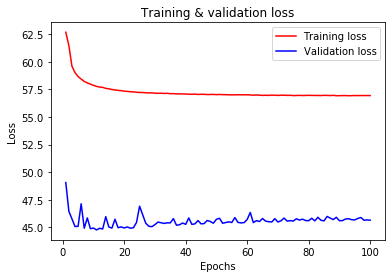

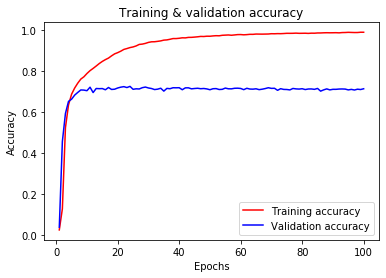

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print('accuracy:',max(val_acc))

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 32 Channel MARS with Different layers

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os, sys
from tqdm import tqdm
from scipy import io
    
MMI_SUBJECT = 100
MMI_CHANNEL = 64
channel_num = [21, 25, 31, 29, 0, 2, 8, 40, 14 ,16 ,48, 46, 56, 60, 61, 50, 
               23, 27, 33, 35, 37, 6, 4, 10, 12, 41, 20, 18, 52, 54, 58, 62]

train32chan_data = []
test32chan_data = []
train64chan_data = []
test64chan_data = []

load_path = './eegmmidb_feature/S'

for i in tqdm(range(MMI_SUBJECT)):
    if(i == 105): continue
    path = load_path+str(i+1).zfill(3)+'/'
    temp = np.load(path+'user_id_20_8.npy')
    temp2 = temp[:,:,channel_num]
    temp3 = temp2[:,channel_num,:]
    cut_off = int(len(temp3) * 0.8)
    train64chan_data.append(temp[:cut_off])
    test64chan_data.append(temp[cut_off:])
    train32chan_data.append(temp3[:cut_off])
    test32chan_data.append(temp3[cut_off:])
       
train64chan_data = np.array(train64chan_data)
test64chan_data = np.array(test64chan_data)
train32chan_data = np.array(train32chan_data)
test32chan_data = np.array(test32chan_data)
print(train64chan_data.shape, test64chan_data.shape)
print(train32chan_data.shape, test32chan_data.shape)

train64chan_data = train64chan_data.reshape(-1,64,64,1)
test64chan_data = test64chan_data.reshape(-1,64,64,1)
train32chan_data = train32chan_data.reshape(-1,32,32,1)
test32chan_data = test32chan_data.reshape(-1,32,32,1)
print(train64chan_data.shape, test64chan_data.shape)
print(train32chan_data.shape, test32chan_data.shape)

train_label = np.zeros((len(train32chan_data), MMI_SUBJECT))
test_label = np.zeros((len(test32chan_data), MMI_SUBJECT))

for i in range(len(train_label)):
    k = int(i/(len(train_label)/100))
    train_label[i][k] = 1

for i in range(len(test_label)):
    k = int(i/(len(test_label)/100))
    test_label[i][k] = 1

print(train_label.shape, test_label.shape)

In C:\Users\jae\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\jae\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\jae\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\jae\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\jae\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
Th

(100, 780, 64, 64) (100, 195, 64, 64)
(100, 780, 32, 32) (100, 195, 32, 32)
(78000, 64, 64, 1) (19500, 64, 64, 1)
(78000, 32, 32, 1) (19500, 32, 32, 1)
(78000, 100) (19500, 100)


In [3]:
#shuffle
idx = [i for i in range(len(train64chan_data))]
np.random.shuffle(idx)
train64chan_data = train64chan_data[idx]
train32chan_data = train32chan_data[idx]
train_label = train_label[idx]

In [4]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Reshape, Conv2D, Dense, Input, Activation
from keras.layers import Dropout, BatchNormalization, MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

tf.__version__

Using TensorFlow backend.


'2.1.0'

In [62]:
class ResizeLayer(keras.layers.Layer):
    def __init__(self):
        super(ResizeLayer, self).__init__()
        
    def call(self, inputs):
        return tf.image.resize(inputs, [30,30])
    
resizelayer = ResizeLayer()

In [70]:
K.tensorflow_backend.clear_session()

MMI_SUBJECT = 100
teacher_model = keras.models.load_model('MMI_44.h5')
tea_feature = teacher_model.layers[3].output    # -2, 9, 6, 3
tea_feature = resizelayer(tea_feature)

inputs = Input(shape=(32,32,1), name='input')
x = Conv2D(32, (1,32), activation='relu', name='1dconv1')(inputs)
x = Reshape((32,32,1), name='reshape')(x)
std_feature = Conv2D(8, (3,3), activation='relu', name='2dconv1')(x)
x = BatchNormalization(name='bn1')(std_feature)
x = Dropout(0.4, name='dp1')(x)
x = Conv2D(8, (3,3), activation='relu', name='2dconv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Dropout(0.4, name='dp2')(x)
x = Conv2D(8, (3,3), activation='relu', name='2dconv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Dropout(0.4, name='dp3')(x)
x = Flatten(name='flat')(x)
x = Dense(2048, activation='relu', name='fc')(x)
prediction = Dense(MMI_SUBJECT, activation='sigmoid', name='pred')(x)
student_model = Model(inputs=inputs, outputs=prediction)

model = Model(inputs=[teacher_model.input, student_model.input], outputs=student_model.output)

teacher_model.summary()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 1, 64)         4160      
_________________________________________________________________
reshape_1 (Reshape)          (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 8)         32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 8)         584 

In [71]:
def MARS_loss(y_true, y_pred):
    alpha = 15.0
    loss = keras.losses.categorical_crossentropy(y_true, y_pred) + alpha * K.mean(K.square(tea_feature-std_feature))
    return loss

sgd = keras.optimizers.sgd()
adam = keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=sgd,
              loss=MARS_loss,
              metrics=['accuracy'])

for l in teacher_model.layers:
    l.trainable = False

In [72]:
history = model.fit([train64chan_data, train32chan_data], train_label, epochs=60, batch_size=20,
                    validation_data=([test64chan_data, test32chan_data], test_label), verbose=2)

Train on 78000 samples, validate on 19500 samples
Epoch 1/60
 - 33s - loss: 4.0245 - accuracy: 0.1210 - val_loss: 3.1725 - val_accuracy: 0.2907
Epoch 2/60
 - 32s - loss: 2.2331 - accuracy: 0.4600 - val_loss: 2.0832 - val_accuracy: 0.5001
Epoch 3/60
 - 32s - loss: 1.7403 - accuracy: 0.5700 - val_loss: 1.9996 - val_accuracy: 0.5296
Epoch 4/60
 - 32s - loss: 1.5108 - accuracy: 0.6225 - val_loss: 1.6330 - val_accuracy: 0.6035
Epoch 5/60
 - 32s - loss: 1.3665 - accuracy: 0.6567 - val_loss: 1.5415 - val_accuracy: 0.6311
Epoch 6/60
 - 32s - loss: 1.2438 - accuracy: 0.6843 - val_loss: 1.4692 - val_accuracy: 0.6425
Epoch 7/60
 - 32s - loss: 1.1409 - accuracy: 0.7060 - val_loss: 1.4881 - val_accuracy: 0.6383
Epoch 8/60
 - 32s - loss: 1.0530 - accuracy: 0.7274 - val_loss: 1.4292 - val_accuracy: 0.6546
Epoch 9/60
 - 32s - loss: 0.9900 - accuracy: 0.7440 - val_loss: 1.3998 - val_accuracy: 0.6629
Epoch 10/60
 - 32s - loss: 0.9342 - accuracy: 0.7587 - val_loss: 1.4896 - val_accuracy: 0.6424
Epoch 11/

accuracy: 0.6852820515632629


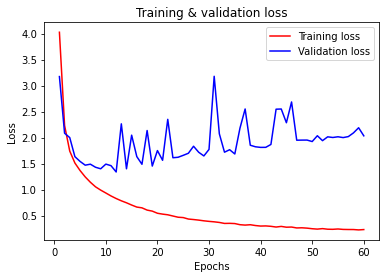

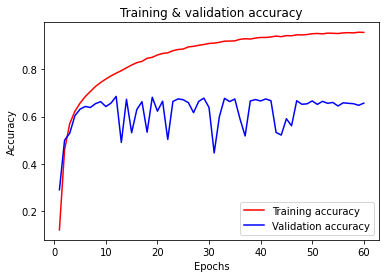

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print('accuracy:',max(val_acc))

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 그냥 실험

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 1)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 64, 1)         0         
_________________________________________________________________
1dconv1 (Conv2D)             (None, 64, 1, 64)         4160      
_________________________________________________________________
reshape (Reshape)            (None, 64, 64, 1)         0         
_________________________________________________________________
2dconv1 (Conv2D)             (None, 62, 62, 8)         80        
_________________________________________________________________
bn1 (BatchNormalization)     (None, 62, 62, 8)         32        
_________________________________________________________________
dp1 (Dropout)                (None, 62, 62, 8)         0   

Epoch 61/80
 - 62s - loss: 0.0105 - accuracy: 0.9966 - val_loss: 1.7868 - val_accuracy: 0.7608
Epoch 62/80
 - 62s - loss: 0.0109 - accuracy: 0.9964 - val_loss: 1.7716 - val_accuracy: 0.7693
Epoch 63/80
 - 61s - loss: 0.0129 - accuracy: 0.9958 - val_loss: 1.7508 - val_accuracy: 0.7674
Epoch 64/80
 - 62s - loss: 0.0104 - accuracy: 0.9966 - val_loss: 1.7517 - val_accuracy: 0.7649
Epoch 65/80
 - 62s - loss: 0.0095 - accuracy: 0.9968 - val_loss: 1.7819 - val_accuracy: 0.7666
Epoch 66/80
 - 62s - loss: 0.0093 - accuracy: 0.9970 - val_loss: 1.7340 - val_accuracy: 0.7693
Epoch 67/80
 - 61s - loss: 0.0093 - accuracy: 0.9971 - val_loss: 1.8237 - val_accuracy: 0.7563
Epoch 68/80
 - 62s - loss: 0.0103 - accuracy: 0.9967 - val_loss: 1.7655 - val_accuracy: 0.7660
Epoch 69/80
 - 62s - loss: 0.0081 - accuracy: 0.9973 - val_loss: 1.7582 - val_accuracy: 0.7667
Epoch 70/80
 - 62s - loss: 0.0085 - accuracy: 0.9972 - val_loss: 1.7420 - val_accuracy: 0.7677
Epoch 71/80
 - 62s - loss: 0.0102 - accuracy: 0.99

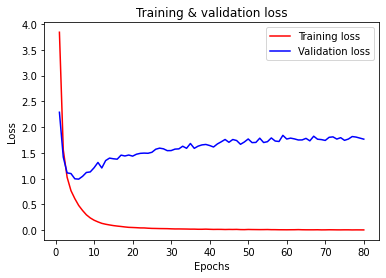

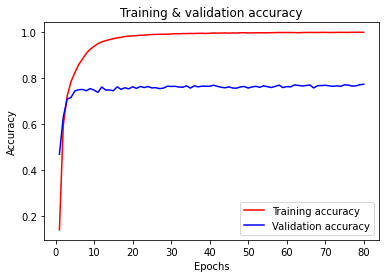

In [82]:
K.tensorflow_backend.clear_session()

MMI_SUBJECT = 100

inputs = Input(shape=(32,32,1), name='input')
x = keras.layers.UpSampling2D(size=(2,2))(inputs)
x = Conv2D(64, (1,64), activation='relu', name='1dconv1')(x)
x = Reshape((64,64,1), name='reshape')(x)
x = Conv2D(8, (3,3), activation='relu', name='2dconv1')(x)
x = BatchNormalization(name='bn1')(x)
x = Dropout(0.4, name='dp1')(x)
x = Conv2D(8, (3,3), activation='relu', name='2dconv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Dropout(0.4, name='dp2')(x)
x = Conv2D(8, (3,3), activation='relu', name='2dconv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Dropout(0.4, name='dp3')(x)
x = Flatten(name='flat')(x)
x = Dense(2048, activation='relu', name='fc')(x)
prediction = Dense(MMI_SUBJECT, activation='sigmoid', name='pred')(x)
model = Model(inputs=inputs, outputs=prediction)

model.summary()

sgd = keras.optimizers.sgd()
adam = keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train32chan_data, train_label, epochs=80, batch_size=20,
                    validation_data=(test32chan_data, test_label), verbose=2)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print('accuracy:',max(val_acc))

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 32, 1)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 64, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 100)               55328228  
Total params: 55,328,228
Trainable params: 55,328,180
Non-trainable params: 48
_________________________________________________________________
Train on 78000 samples, validate on 19500 samples
Epoch 1/80
 - 63s - loss: 2.5242 - accuracy: 0.4101 - val_loss: 1.4792 - val_accuracy: 0.6266
Epoch 2/80
 - 62s - loss: 1.0426 - accuracy: 0.7165 - val_loss: 1.1645 - val_accuracy: 0.7005
Epoch 3/80
 - 62s - loss: 0.7376 - accuracy: 0.7912 - val_loss: 1.0543 - val_accuracy: 0.7297
Epoch 4/80
 - 62s - loss: 0.5570 - accuracy:

Epoch 79/80
 - 62s - loss: 0.0064 - accuracy: 0.9978 - val_loss: 1.8246 - val_accuracy: 0.7682
Epoch 80/80
 - 63s - loss: 0.0077 - accuracy: 0.9974 - val_loss: 1.8101 - val_accuracy: 0.7683
accuracy: 0.7699487209320068


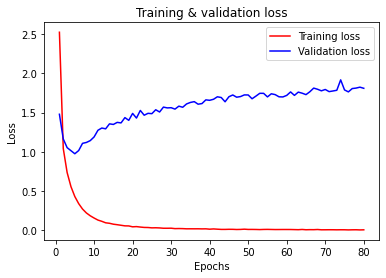

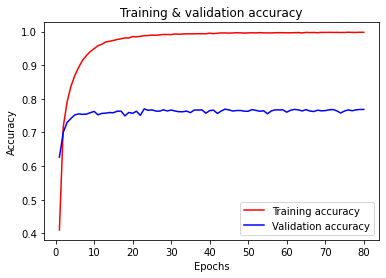

In [10]:
K.tensorflow_backend.clear_session()
teacher_model = keras.models.load_model('MMI_44.h5')
teacher_model.layers.pop(0)

inputs = Input(shape=(32,32,1), name='input')
x = keras.layers.UpSampling2D(size=(2,2))(inputs)
predictions = teacher_model(x)
pretrained_model = Model(inputs=inputs, outputs=predictions)

pretrained_model.summary()

sgd = keras.optimizers.sgd()
pretrained_model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = pretrained_model.fit(train32chan_data, train_label, epochs=80, batch_size=20,
                    validation_data=(test32chan_data, test_label), verbose=2)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print('accuracy:',max(val_acc))

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()